In [1]:
import numpy as np
import scipy
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import seaborn as sns
import re
from tqdm import tqdm
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
import math
import nltk
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
from bs4 import BeautifulSoup
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation, NMF, SparsePCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, multilabel_confusion_matrix, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
import xml.etree.ElementTree as etree
import time
import spacy
from spacy import displacy
from wordcloud import WordCloud

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.min_rows', 50)

## Fonctions

In [24]:
class Model:
    def __init__(self, y_train, y_test):
        self.models = pd.DataFrame(columns=[
            'name',
            'grid_params',
            'best_params',
            'data_use',
            'model',
            'error',
            'Precision',
            'Recall',
            'F_mesure',
            'proportion_de_prédiction',
            'auc_micro',
            'auc_macro',
            'params'
        ])
        self.y_train = y_train
        self.y_test = y_test
        self.x = {}
    def add_model(self, name, model, params=None):
        """
        Effectue une recherche par grille sur les paramètres.
        """
        self.models = self.models.append({
            'name': name,
            'grid_params': params,
            'model': model
        }, ignore_index=True)
    def add_data(self, data_name, x_train, x_test):
        self.x[data_name] = {
            'x_train': x_train,
            'x_test': x_test
        }
    def fit(self, name='all', data_name=None, cv=None):
        if name == 'all':
            self.models.apply(lambda x: self._fit_process(x, data_name, cv), axis=1)
        elif type(name) == str:
            self._fit_process(self.models[self.models['name'] == name], data_name, cv)
        elif type(name) == list:
            for model_name in name:
                self._fit_process(self.models[self.models['name'] == model_name], data_name, cv)
    def _fit_process(self, model, data_name, cv):
        if data_name == None:
            data_name = list(self.x.keys())[-1]
        x_train = self.x[data_name]['x_train']
        x_test = self.x[data_name]['x_test']
        if model['grid_params'] != None:
            grid = GridSearchCV(model['model'], model['grid_params'], n_jobs=-1, cv=cv)
            grid.fit(x_train, self.y_train)
            model['model'] = grid.best_estimator_
        model['model'].fit(x_train, self.y_train)
        print('le model '+model['name']+' à fini son entrainement')
        model['best_params'] = model['model'].get_params()
        model['data_use'] = data_name
        y_pred = model['model'].predict(x_test)
        mcm = multilabel_confusion_matrix(self.y_test, y_pred)
        tn = mcm[:, 0, 0].mean()
        tp = mcm[:, 1, 1].mean()
        fn = mcm[:, 1, 0].mean()
        fp = mcm[:, 0, 1].mean()
        model['error'] = (fp+fn)/(tn+tp+fp+fn)
        model['Precision'] = tp/(tp+fp)
        model['Recall'] = tp/(tp+fn)
        model['F_mesure'] = (2*tp)/(2*tp+fp+fn)
        model['proportion_de_prédiction'] = (tp + fp)/(tp + fn)
        
        y_prob = model['model'].predict_proba(x_test)
        y_proba = []
        for i in y_prob:
            y_proba.append(i[:,0])
        y_proba = 1 - np.array(y_proba).T
        
        n_classes = y_pred.shape[1]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(self.y_test[:, i], y_proba[:, i])
            if self.y_test[:, i].sum() == 0:
                tpr[i] = fpr[i]
            roc_auc[i] = auc(fpr[i], tpr[i])
            
        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(self.y_test.ravel(), y_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes
        
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        model['auc_micro'] = roc_auc["micro"]
        model['auc_macro'] = roc_auc["macro"]
        model['params'] = {
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
        print('tout est bon pour le model '+model['name'])
    def plot_roc(self, name):
        model = self.models[self.models['name'] == name]
        fpr = model['params']['fpr']
        tpr = model['params']['tpr']
        roc_auc = model['params']['roc_auc']
        
        plt.figure(figsize=[15,15])
        plt.plot(
            fpr["micro"],
            tpr["micro"],
            label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"])
        )

        plt.plot(
            fpr["macro"],
            tpr["macro"],
            label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"])
        )
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Some extension of Receiver operating characteristic to multiclass")
        plt.legend(loc="lower right")
        plt.show()

In [3]:
def plot_top_words(model, feature_names, n_top_words, nb_line_plot, title):
    """Function for displaying the plots of the 
    best x words representative of the categories of NMF.

    Parameters
    ----------------------------------------
    model : NMF model
        Fitted model of NMF to plot
    feature_names : array
        Categories result of the vectorizer (TFIDF ...)
    n_top_words : int
        Number of words for each topic.
    title : string
        Title of the plot.
    ----------------------------------------
    """
    rows = int(nb_line_plot)
    fig, axes = plt.subplots(rows, 6, 
                             figsize=(30, rows*10), 
                             sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_line_plot*6):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Préparation

In [4]:
post = pd.read_csv('Data/Posts_Clean_1.csv', index_col=0, converters={'Tags_list' : str, 'Text' : str})
vocabulary = np.load('Data/Vocabulary.npy', allow_pickle=True)
post = post.sample(n=10000)

In [5]:
X = post["Text"].values
Y = post["Tags_list"].str.split().values
x_train, x_test, y_train, y_test = train_test_split(
  X, Y, test_size=0.2, random_state=9000)

In [6]:
tags_binarizer = MultiLabelBinarizer()
tags_binarizer.fit(y_train)
y_train = tags_binarizer.transform(y_train)
y_test = tags_binarizer.transform(y_test)

count_vect = CountVectorizer(lowercase=False, token_pattern=r"\S+", vocabulary=vocabulary)
count_vect.fit(x_train)
x_train_counts = count_vect.transform(x_train)
x_test_counts = count_vect.transform(x_test)

tf_idn = TfidfTransformer()
tf_idn.fit(x_train_counts)
x_train_tfidf = tf_idn.transform(x_train_counts)
x_test_tfidf = tf_idn.transform(x_test_counts)

## Supervisée

In [45]:
tSVD = TruncatedSVD(n_components=300)
tSVD.fit(x_train_tfidf)
x_train_Tsvd = tSVD.transform(x_train_tfidf)
x_test_Tsvd = tSVD.transform(x_test_tfidf)

In [140]:
acp = PCA(n_components=300)
acp.fit(x_train_tfidf)
x_train_acp = acp.transform(x_train_tfidf)
x_test_acp = acp.transform(x_test_tfidf)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

In [87]:
lda = LatentDirichletAllocation(
    n_components=30, 
    n_jobs=-1)
lda.fit(x_train_counts)

LatentDirichletAllocation(n_components=30, n_jobs=-1)

In [88]:
x_train_lda = lda.transform(x_train_counts)

In [102]:
np.concatenate((x_test_tfidf, x_train_lda), axis=1).shape

ValueError: zero-dimensional arrays cannot be concatenated

In [1]:
x_train_counts

NameError: name 'x_train_counts' is not defined

In [208]:
model = Model(y_train=y_train, y_test=y_test)
model.add_data(data_name='tf-idf', x_train=x_train_tfidf, x_test=x_test_tfidf)

In [209]:
forest = RandomForestClassifier(n_jobs=-1)
model.add_model('forest', forest)

In [210]:
model.fit()

In [198]:
model.models

,name,grid_params,best_params,model,error,Precision,Recall,F_mesure,proportion_de_prédiction,auc_micro,auc_macro,params
0,forest,None,NaN,"(DecisionTreeClassifier(max_features='auto', r...",0.004063,0.882947,0.212224,0.342198,0.240359,NaN,NaN,"{'fpr': {0: [0.0, 0.0, 0.0, 0.0005010020040080..."


In [190]:
test.apply(lambda x: print(x), axis=1)

name                                                   forest
grid_params                                              None
best_params                                               NaN
model                       RandomForestClassifier(n_jobs=-1)
error                                                     NaN
Precision                                                 NaN
Recall                                                    NaN
F_mesure                                                  NaN
proportion_de_prédiction                                  NaN
auc_micro                                                 NaN
auc_macro                                                 NaN
params                                                    NaN
Name: 0, dtype: object
name                                                  forest2
grid_params                                              None
best_params                                               NaN
model                       RandomForestClassif

0    None
1    None
dtype: object

In [188]:
for lop in range(test.shape[1]):
    test.iloc
test.apply(lambda x: print(x))

name                                                   forest
grid_params                                              None
best_params                                               NaN
model                       RandomForestClassifier(n_jobs=-1)
error                                                     NaN
Precision                                                 NaN
Recall                                                    NaN
F_mesure                                                  NaN
proportion_de_prédiction                                  NaN
auc_micro                                                 NaN
auc_macro                                                 NaN
params                                                    NaN
Name: 0, dtype: object
name                                                  forest2
grid_params                                              None
best_params                                               NaN
model                       RandomForestClassif

In [142]:
test = pd.DataFrame({'name': 'forest', 'model': forest})

In [147]:
test['model'].apply(lambda x: x.predict(x_test_tfidf))

0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
5     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
6     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
7     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
8     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
9     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
11    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
12    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
13    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
14    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
15    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
16    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
17    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [69]:
forest = RandomForestClassifier(n_jobs=-1)
forest.fit(x_train_tfidf, y_train)
Y_Pred = forest.predict(x_test_tfidf)

ValueError: X has 100 features, but RandomForestClassifier is expecting 9947 features as input.

In [72]:
Y_Prob = forest.predict_proba(x_test_tfidf)
Y_Proba = []
for i in Y_Prob:
    Y_Proba.append(i[:,0])
Y_Proba = 1 - np.array(Y_Proba).T

In [137]:
n_classes = y_train.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], Y_Proba[:, i])
    if y_test[:, i].sum() == 0:
        tpr[i] = fpr[i]
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), Y_Proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn

In [138]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

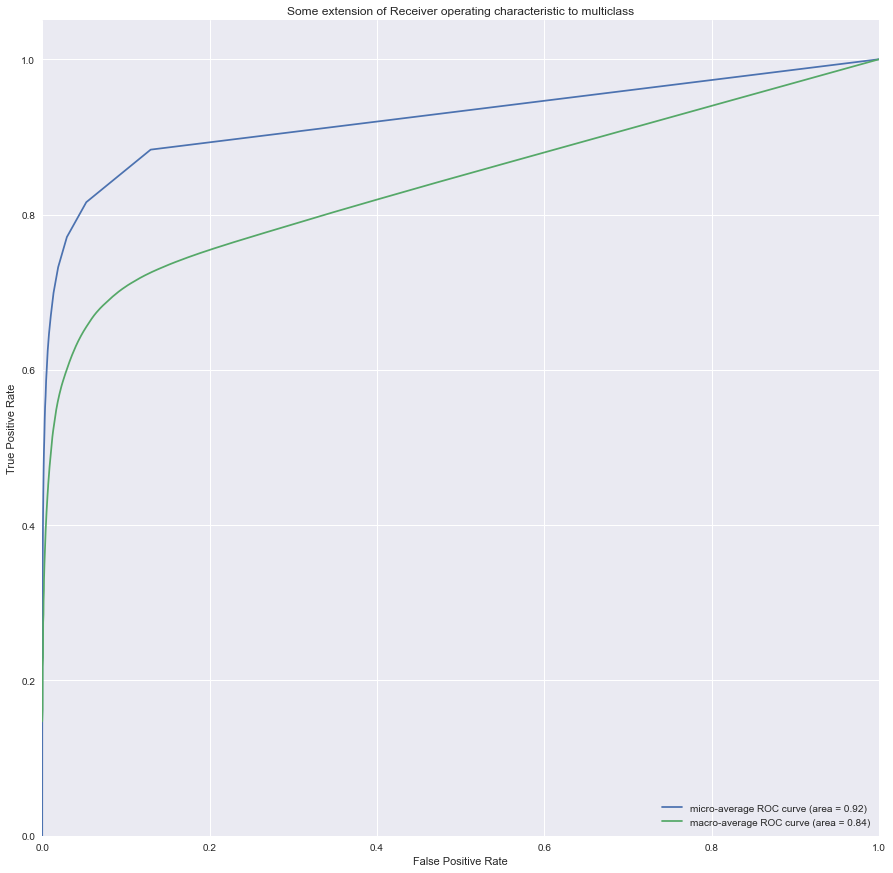

In [156]:
# Plot all ROC curves

plt.figure(figsize=[15,15])
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"])
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"])
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [83]:
i = 0.5
mcm = multilabel_confusion_matrix(y_test, Y_Pred)
tn = mcm[:, 0, 0].mean()
tp = mcm[:, 1, 1].mean()
fn = mcm[:, 1, 0].mean()
fp = mcm[:, 0, 1].mean()
while (tp + fp) < (tp + fn):
    Y_Est = Y_Proba > i
    mcm = multilabel_confusion_matrix(y_test, Y_Est)
    tn = mcm[:, 0, 0].mean()
    tp = mcm[:, 1, 1].mean()
    fn = mcm[:, 1, 0].mean()
    fp = mcm[:, 0, 1].mean()
    i -= 0.001
print(i)

0.13899999999999968


In [76]:
mcm = multilabel_confusion_matrix(y_test, Y_Pred)
tn = mcm[:, 0, 0].mean()
tp = mcm[:, 1, 1].mean()
fn = mcm[:, 1, 0].mean()
fp = mcm[:, 0, 1].mean()

In [86]:
[[tn,fn], [fp, tp]]

[[1984.695652173913, 4.785024154589372],
 [5.345410628019324, 5.173913043478261]]

In [84]:
(tp + fp)/(tp + fn)

10.519323671497585

In [85]:
tp + fn

9.958937198067634

## Non-Supervisée

In [ ]:
texts = count_vect.inverse_transform(x_train_counts)
dico = Dictionary(texts)
corpus = [dico.doc2bow(text) for text in texts]

In [ ]:
[[(dico[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accomplish', 1),
  ('active', 1),
  ('additional', 1),
  ('address', 1),
  ('administrative', 1),
  ('anyone', 1),
  ('appears', 1),
  ('believe', 1),
  ('cn', 1),
  ('contains', 1),
  ('content', 1),
  ('e-mail', 1),
  ('email', 1),
  ('ex', 1),
  ('examine', 1),
  ('exchange', 1),
  ('external', 1),
  ('field', 1),
  ('group', 1),
  ('information', 1),
  ('instance', 1),
  ('mapi', 1),
  ('might', 1),
  ('mm', 1),
  ('normal', 1),
  ('obtain', 1),
  ('ou', 1),
  ('pull', 1),
  ('query', 1),
  ('recipient', 1),
  ('returned', 1),
  ('see', 1),
  ('smtp', 1),
  ('sort', 1),
  ('structure', 1),
  ('via', 1)]]

In [ ]:
# Build LDA model
lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=dico,
                                  num_topics=20,
                                  random_state=100,
                                  per_word_topics=True)
# Print Perplexity score
print('Perplexity: ', lda.log_perplexity(corpus))

#Print Coherence Score
coherence_model_lda = CoherenceModel(model=lda, 
                                     texts=texts, 
                                     dictionary=dico, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -8.629061800247843
Coherence Score:  0.4758168490813587


In [ ]:
coherence_score = []
time_fit = []
params = range(5,65,5)
for param in tqdm(params):
    start = time.time()
    lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                id2word=dico,
                                                num_topics=param,
                                                random_state=24,
                                                per_word_topics=True)
    stop = time.time()
    coherence_model_lda = CoherenceModel(model=lda, 
                                                texts=texts, 
                                                dictionary=dico, 
                                                coherence='c_v')
    coherence_score.append(coherence_model_lda.get_coherence())
    time_fit.append(stop - start)

100%|██████████| 12/12 [06:13<00:00, 31.11s/it]


Text(0, 0.5, "Temps d'execution")

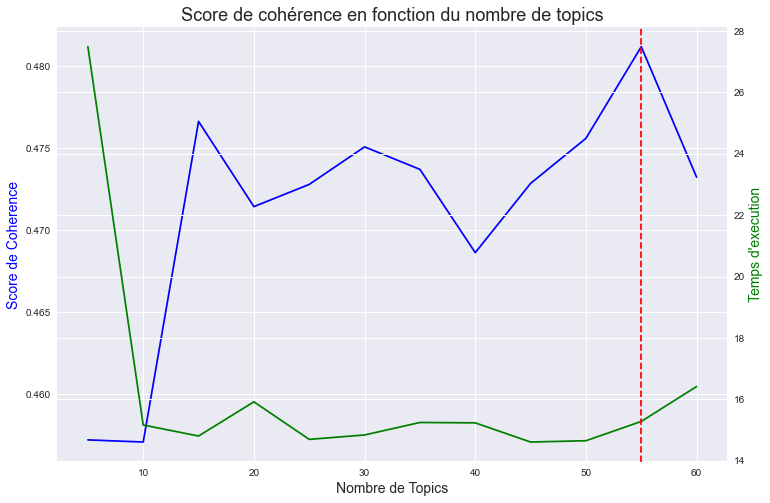

In [ ]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax1.plot(params, coherence_score, color="b")
ax2.plot(params, time_fit, color="g")
plt.axvline(55, color="r", linestyle='--', label="Le meileur paramètre est : 20")
plt.title("Score de cohérence en fonction du nombre de topics", fontsize=18)
ax1.set_xlabel("Nombre de Topics", fontsize=14)
ax1.set_ylabel("Score de Coherence", fontsize=14, color="b")
ax2.set_ylabel("Temps d'execution", fontsize=14, color="g")

In [ ]:
best_lda = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                  id2word=dico,
                                  num_topics=55)

In [ ]:
pyLDAvis.enable_notebook()

gensimvis.prepare(best_lda, corpus, dico)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.004179  0.005921       1        1  3.283643
20    -0.007336 -0.000911       2        1  2.882383
43     0.011602  0.008338       3        1  2.617258
10     0.001669 -0.018959       4        1  2.509342
45     0.007873  0.002452       5        1  2.438816
40    -0.001601 -0.012505       6        1  2.417813
18     0.001424  0.011937       7        1  2.410027
41     0.000779 -0.005105       8        1  2.389234
7     -0.005295 -0.026731       9        1  2.313855
26     0.001661 -0.011140      10        1  2.285484
24     0.001164 -0.001225      11        1  2.201108
44     0.010787 -0.001868      12        1  2.163120
30    -0.007025 -0.006669      13        1  2.159488
22     0.007082 -0.000629      14        1  2.075502
48    -0.003100 -0.012160      15        1  2.035250
53     0.002734 -0.006434      16        1  2.015786
42    -0.002319 -0.009454      17        1  1.981142
4      0.012665 -0.009570      18        1  1.971043
32     0.008106 -0.014265      19        1  1.955545
52    -0.005993 -0.005325      20        1  1.947522
38     0.019090  0.007401      21        1  1.913073
8      0.008175 -0.009690      22        1  1.911647
2      0.013471 -0.011263      23        1  1.889046
35     0.006812  0.002067      24        1  1.865994
47    -0.012883 -0.020827      25        1  1.861965
12     0.009640 -0.013614      26        1  1.844339
37     0.010208 -0.013499      27        1  1.792302
25     0.007790  0.006278      28        1  1.791672
19     0.002007  0.013837      29        1  1.786822
36    -0.001512 -0.017434      30        1  1.731524
21     0.027466  0.021247      31        1  1.724247
16    -0.000614 -0.011871      32        1  1.710184
27    -0.014250 -0.022496      33        1  1.672064
6      0.007148  0.006402      34        1  1.655475
3     -0.001919 -0.001349      35        1  1.646425
31     0.013491 -0.019200      36        1  1.645952
1     -0.021486 -0.005069      37        1  1.644777
29    -0.002043  0.015403      38        1  1.630649
28     0.011133 -0.009137      39        1  1.586599
51     0.007943 -0.012085      40        1  1.533233
33     0.009201 -0.000922      41        1  1.522620
9      0.005980 -0.015642      42        1  1.511261
34     0.004358  0.006628      43        1  1.477515
17    -0.000664 -0.001411      44        1  1.461516
11     0.039044  0.026079      45        1  1.440525
14    -0.008640  0.022960      46        1  1.434602
23     0.001327 -0.013385      47        1  1.365427
15    -0.001484 -0.001103      48        1  1.355702
5     -0.023679 -0.004267      49        1  1.328504
13     0.014317  0.003377      50        1  1.206339
46    -0.034566 -0.021828      51        1  1.125289
39    -0.024903  0.129571      52        1  1.100310
50     0.024150  0.014946      53        1  1.066798
54     0.011009  0.062825      54        1  0.925681
49    -0.144174  0.001375      55        1  0.786560, topic_info=             Term        Freq       Total Category  logprob  loglift
644           php  464.000000  464.000000  Default  30.0000  30.0000
267         tried  627.000000  627.000000  Default  29.0000  29.0000
125            c#  516.000000  516.000000  Default  28.0000  28.0000
390          used  605.000000  605.000000  Default  27.0000  27.0000
595       working  680.000000  680.000000  Default  26.0000  26.0000
878     currently  340.000000  340.000000  Default  25.0000  25.0000
325        return  539.000000  539.000000  Default  24.0000  24.0000
17           view  450.000000  450.000000  Default  23.0000  23.0000
852           row  275.000000  275.000000  Default  22.0000  22.0000
291         write  404.000000  404.000000  Default  21.0000  21.0000
154       program  374.000000  374.000000  Default  20.0000  20.0000
247       instead  406.000000  406.000000  Default  19.0000  19.0000
572        please  453.000000  453.0000

In [ ]:
lda = LatentDirichletAllocation(
    n_jobs=-1)
params = {"n_components": range(5,65,5)}
grid = GridSearchCV(lda, params, cv=5, n_jobs=-1, verbose=3)
grid.fit(x_train_counts)

In [ ]:
lda = LatentDirichletAllocation(
    n_components=30, 
    n_jobs=-1)
lda.fit(x_train_counts)

LatentDirichletAllocation(n_components=30, n_jobs=-1)

In [ ]:
pyLDAvis.sklearn.prepare(lda, x_train_counts, count_vect)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13    -0.181108  0.080219       1        1  6.589080
3     -0.040907 -0.183216       2        1  5.841385
0      0.115486  0.048781       3        1  4.458945
21     0.031477 -0.057179       4        1  4.193603
14     0.101503 -0.041260       5        1  4.155410
11     0.075770  0.011819       6        1  4.019548
12    -0.057935 -0.057281       7        1  3.879212
23    -0.100315 -0.096777       8        1  3.830922
7      0.070625  0.094648       9        1  3.793981
6      0.031587 -0.054483      10        1  3.777289
8     -0.023497 -0.013440      11        1  3.581003
2     -0.006407 -0.089984      12        1  3.335434
9     -0.024170  0.035482      13        1  3.282011
19     0.065922  0.058134      14        1  3.160963
10     0.075023  0.036731      15        1  3.154494
5      0.076468  0.073032      16        1  3.082987
15    -0.257378  0.078726      17        1  3.040309
20     0.071437  0.146206      18        1  2.985818
28     0.092499 -0.046722      19        1  2.949836
27    -0.057014 -0.004554      20        1  2.798454
22    -0.030736 -0.038840      21        1  2.793580
29     0.015235 -0.025051      22        1  2.642256
18    -0.033990 -0.093052      23        1  2.640907
16     0.042189 -0.014418      24        1  2.575468
1      0.003071  0.035562      25        1  2.538722
4     -0.145491  0.076239      26        1  2.426777
24     0.061881 -0.026651      27        1  2.289857
25     0.029089 -0.067763      28        1  2.267867
17    -0.032119  0.045138      29        1  2.005983
26     0.031806  0.089953      30        1  1.907901, topic_info=            Term         Freq        Total Category  logprob  loglift
15         query   935.000000   935.000000  Default  30.0000  30.0000
16       control   821.000000   821.000000  Default  29.0000  29.0000
32        jquery   788.000000   788.000000  Default  28.0000  28.0000
36          test   678.000000   678.000000  Default  27.0000  27.0000
34      property   680.000000   680.000000  Default  26.0000  26.0000
1           view   832.000000   832.000000  Default  25.0000  25.0000
39         array   629.000000   629.000000  Default  24.0000  24.0000
117       thread   469.000000   469.000000  Default  23.0000  23.0000
25       service   662.000000   662.000000  Default  22.0000  22.0000
30        button   771.000000   771.000000  Default  21.0000  21.0000
62           xml   525.000000   525.000000  Default  20.0000  20.0000
58          item   617.000000   617.000000  Default  19.0000  19.0000
33         field   605.000000   605.000000  Default  18.0000  18.0000
8            sql   830.000000   830.000000  Default  17.0000  17.0000
57       library   546.000000   546.000000  Default  16.0000  16.0000
49        column   601.000000   601.000000  Default  15.0000  15.0000
43         event   640.000000   640.000000  Default  14.0000  14.0000
89        python   511.000000   511.000000  Default  13.0000  13.0000
3           text   892.000000   892.000000  Default  12.0000  12.0000
17           php   743.000000   743.000000  Default  11.0000  11.0000
0            web   866.000000   866.000000  Default  10.0000  10.0000
144       visual   413.000000   413.000000  Default   9.0000   9.0000
7           line  1022.000000  1022.000000  Default   8.0000   8.0000
168       studio   371.000000   371.000000  Default   7.0000   7.0000
2           form   914.000000   914.000000  Default   6.0000   6.0000
...          ...          ...          ...      ...      ...      ...
25       service   109.797001   662.355083  Topic30  -3.9370   2.1620
3304      jframe     7.660328    13.415094  Topic30  -6.5995   3.3988
293        state    37.400660   186.687410  Topic30  -5.0139   2.3514
436         base    35.618887   177.371479  Topic30  -5.0627   2.3538
146       iphone    54.272651   383.329581  Topic30  -4.6416   2.0043
278     resource    3

In [ ]:
pyLDAvis.sklearn.prepare(lda, x_test_counts, count_vect)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13    -0.181108  0.080219       1        1  6.664551
3     -0.040907 -0.183216       2        1  6.428898
0      0.115486  0.048781       3        1  4.554634
11     0.075770  0.011819       4        1  4.397509
21     0.031477 -0.057179       5        1  4.054089
12    -0.057935 -0.057281       6        1  4.051440
23    -0.100315 -0.096777       7        1  3.921212
8     -0.023497 -0.013440       8        1  3.907657
14     0.101503 -0.041260       9        1  3.904839
2     -0.006407 -0.089984      10        1  3.882241
7      0.070625  0.094648      11        1  3.626801
6      0.031587 -0.054483      12        1  3.439551
19     0.065922  0.058134      13        1  3.204671
10     0.075023  0.036731      14        1  3.196729
20     0.071437  0.146206      15        1  3.150283
22    -0.030736 -0.038840      16        1  2.981509
9     -0.024170  0.035482      17        1  2.978021
15    -0.257378  0.078726      18        1  2.918172
5      0.076468  0.073032      19        1  2.913814
28     0.092499 -0.046722      20        1  2.817097
29     0.015235 -0.025051      21        1  2.785021
16     0.042189 -0.014418      22        1  2.563237
4     -0.145491  0.076239      23        1  2.556471
27    -0.057014 -0.004554      24        1  2.432782
25     0.029089 -0.067763      25        1  2.382090
1      0.003071  0.035562      26        1  2.371317
18    -0.033990 -0.093052      27        1  2.241394
17    -0.032119  0.045138      28        1  2.132518
24     0.061881 -0.026651      29        1  2.071215
26     0.031806  0.089953      30        1  1.470238, topic_info=            Term        Freq       Total Category  logprob  loglift
15         query  259.000000  259.000000  Default  30.0000  30.0000
34      property  184.000000  184.000000  Default  29.0000  29.0000
32        jquery  200.000000  200.000000  Default  28.0000  28.0000
16       control  191.000000  191.000000  Default  27.0000  27.0000
1           view  222.000000  222.000000  Default  26.0000  26.0000
36          test  164.000000  164.000000  Default  25.0000  25.0000
117       thread  126.000000  126.000000  Default  24.0000  24.0000
62           xml  151.000000  151.000000  Default  23.0000  23.0000
25       service  168.000000  168.000000  Default  22.0000  22.0000
39         array  139.000000  139.000000  Default  21.0000  21.0000
30        button  197.000000  197.000000  Default  20.0000  20.0000
8            sql  225.000000  225.000000  Default  19.0000  19.0000
33         field  157.000000  157.000000  Default  18.0000  18.0000
49        column  161.000000  161.000000  Default  17.0000  17.0000
57       library  140.000000  140.000000  Default  16.0000  16.0000
58          item  151.000000  151.000000  Default  15.0000  15.0000
43         event  152.000000  152.000000  Default  14.0000  14.0000
3           text  225.000000  225.000000  Default  13.0000  13.0000
0            web  225.000000  225.000000  Default  12.0000  12.0000
89        python  121.000000  121.000000  Default  11.0000  11.0000
17           php  180.000000  180.000000  Default  10.0000  10.0000
144       visual   99.000000   99.000000  Default   9.0000   9.0000
7           line  248.000000  248.000000  Default   8.0000   8.0000
168       studio   89.000000   89.000000  Default   7.0000   7.0000
2           form  243.000000  243.000000  Default   6.0000   6.0000
...          ...         ...         ...      ...      ...      ...
3387     escaped    1.909874    4.058819  Topic30  -6.3490   3.4659
25       service   21.308122  168.719863  Topic30  -3.9370   2.1506
3304      jframe    1.486627    2.859441  Topic30  -6.5995   3.5656
293        state    7.258284   46.142742  Topic30  -5.0139   2.3701
436         base    6.912499   43.464537  Topic30  -5.0627   2.3811
146       iphone   10.532604   95.566242  Topic30  -4.6416   2.0144
16       control 

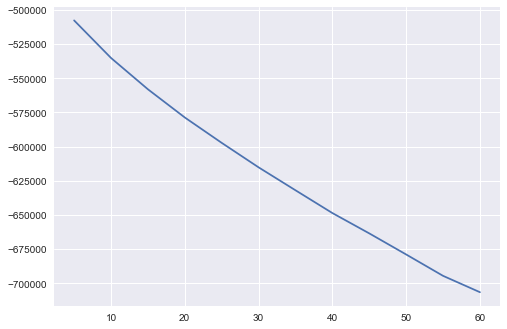

In [ ]:
plt.plot(params["n_components"], grid.cv_results_["mean_test_score"])

In [ ]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(x_test_counts))


# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(x_test_counts))

Log Likelihood:  -96303.1400915431
Perplexity:  101999.2257173945


In [ ]:
# Run NMF
nmf = NMF(n_components=30, random_state=129)
nmf.fit(x_train_counts)
x_nmf = nmf.transform(x_train_counts)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=30, random_state=129)

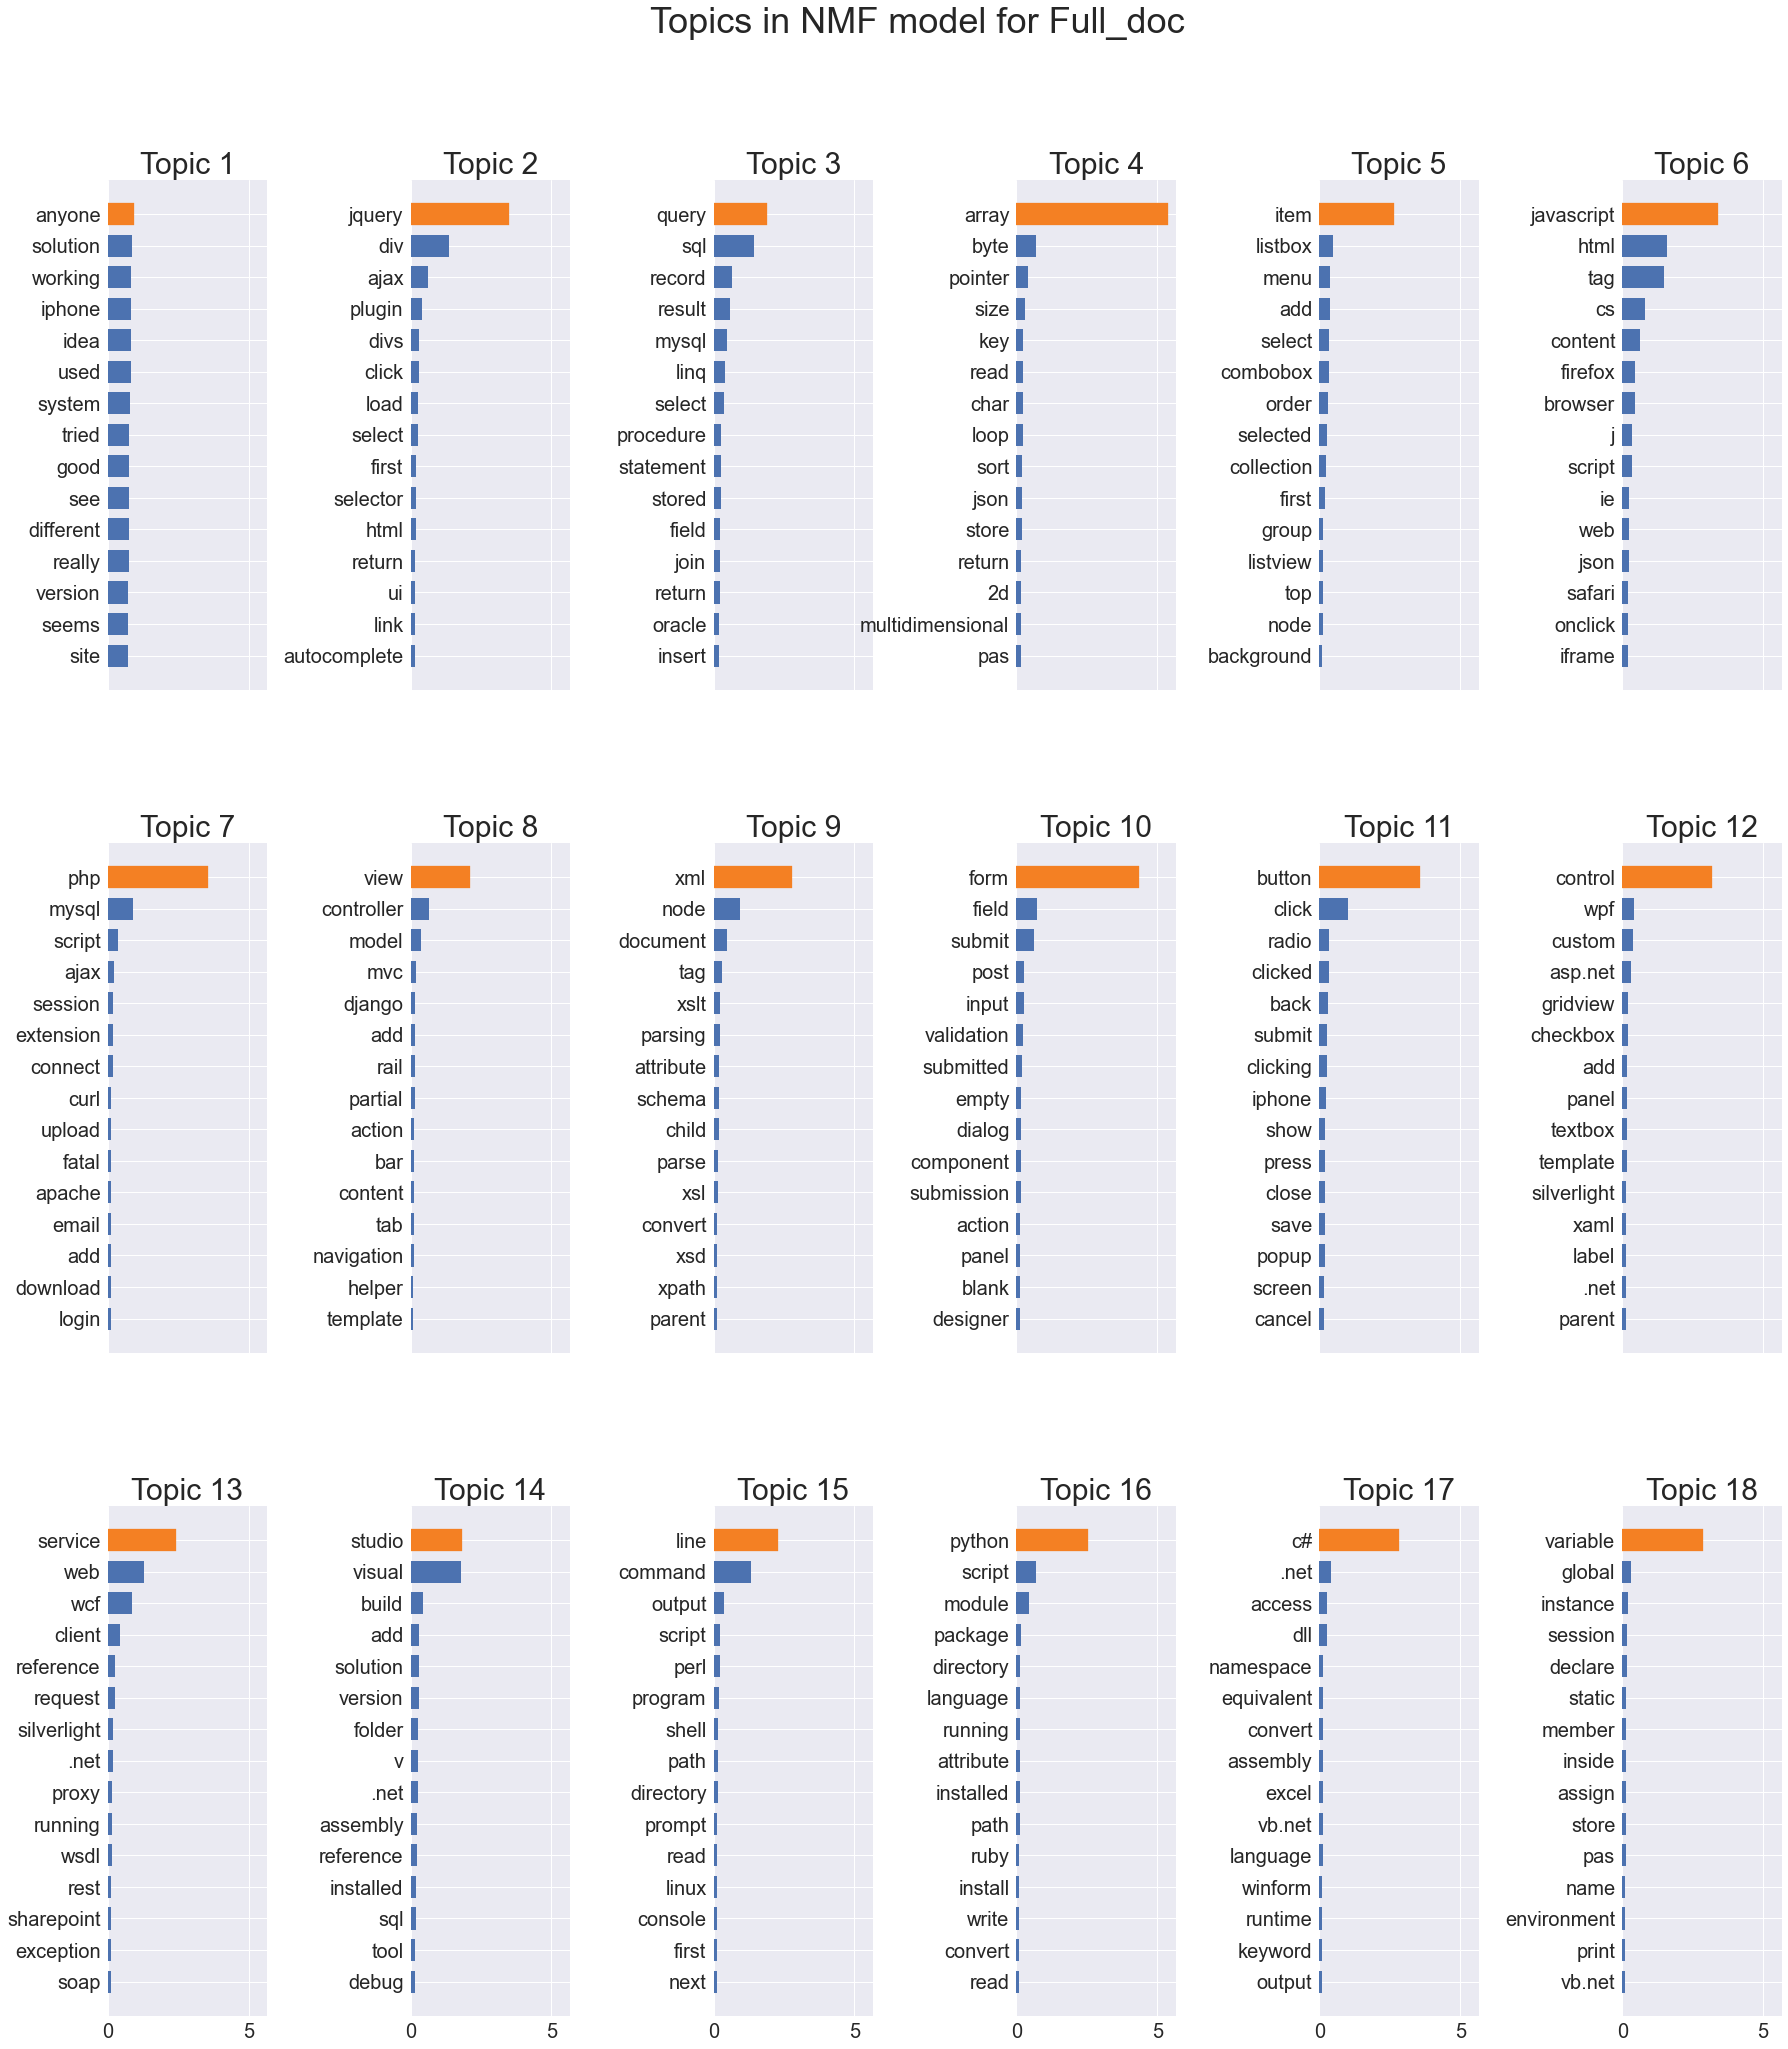

In [ ]:
# Initializing the NMF
full_nmf = NMF(n_components=30, init="nndsvda", random_state=129)

# Fit NMF on Body vectorized
full_nmf.fit(x_train_tfidf)

# Plot the 12 first topics
ff_feature_names = count_vect.get_feature_names_out()
plot_top_words(full_nmf, ff_feature_names, 15, 3,
               'Topics in NMF model for Full_doc')